In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
import ForwardDiff as FD
using JuMP
using COSMO
using Random; 

  Activating environment at `~/SSD/Code/TinyMPC/julia/cone_simple/Project.toml`


In [10]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.

function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
    dx = - p.Xref[k]
    du = - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
    dx = - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    λhat = λc # already updated
    ∇c = cone_u_jac(p, u)
    G = ∇c'*∇projection(λhat)*projection(λhat)
    # H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c/ρ
    H = ∇c'*(∇projection(λhat)'*∇projection(λhat) + ∇²projection(λhat, projection(λhat)))*∇c/ρ
    return (G - H*u), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
    """iLQR backward pass with AL. This !function update its parameters
    """
    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params) 
    
    if (params.ncx > 0)
        # # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])  # h(x) violation  
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])
        # add these into the cost-to-go p and P
        p[N]  += ∇hx'*(μx[N] - ρ*(mask * [params.x_max;-params.x_min]))  # multiplier term (1st)
        P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
    end
    
    if (params.ncg > 0)
        # add AL terms for goal constraint 
        ∇hx = diagm(ones(params.nx))
        # add these into the CTG p and P (equality active)
        p[N]  += ∇hx'*(λ - ρ*params.Xref[N])   
        P[N]  += ρ*∇hx'∇hx
    end
    
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1
        # dynamics jacobians (linearization about previous iterate)
        A = FD.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = FD.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
        
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx += A' * (P[k+1]*f + p[k+1]) 
        Su += B' * (P[k+1]*f + p[k+1]) 
        Sxx += A'*(P[k+1])*A
        Suu += B'*(P[k+1] + reg*I)*B                                     
        Sux = B'*(P[k+1])*A  
        if (params.ncu > 0)
            # control constraints
            huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
            mask = eval_mask(μ[k],huv)  # choose active
            ∇hu = ineq_con_u_jac(params,U[k])
            Su  += ∇hu'*(μ[k] - ρ*(mask * [params.u_max;-params.u_min])) # add to cost
            Suu += ρ*∇hu'*mask*∇hu
        end
        if (params.ncx > 0)
            # state constraints
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            ∇hx = ineq_con_x_jac(params,X[k])
            Sx  += ∇hx'*(μx[k] - ρ*(mask * [params.x_max;-params.x_min]))
            Sxx += ρ*∇hx'*mask*∇hx
        end
        if (params.ncu_cone > 0)
            # conic constraints
            Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ/cone_scale, k)
            # display(Quu)
            Su += Qu
            Suu += Quu
        end
        
        # Calculate Gains
        for i = 1:10
            if isposdef(Suu) == 0
                Suu += reg*I
            end
        end
        F = cholesky(Symmetric(Suu))
        d[k] = F\Su
        K[k] = F\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        P[k] = Sxx + K[k]'*Suu*K[k] - 2*K[k]'*Sux
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; 
                        max_linesearch_iters = 20)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = - d[k] - K[k]*Xn[k] 
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
    X .= Xn
    U .= Un
    return 0, 0
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters = 250,verbose = true,ρ=1,ϕ=10)

    # first check the sizes of everything
    # @assert length(X) == params.N
    # @assert length(U) == params.N-1
    # @assert length(X[1]) == params.nx
    # @assert length(U[1]) == params.nu

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    reg_min = 1e-8
    reg = reg_min

    μ = [zeros(params.ncu) for i = 1:N-1]   # input constraints

    μx = [zeros(params.ncx) for i = 1:N]    # state constraints

    λ = zeros(params.nx)    # goal constraint

    λc = [zeros(params.ncu_cone) for i = 1:N-1]   # goal constraint
    
    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters
        
        J = 0.0
        ΔJ = 0.0
        α = 1.0
        for i = 1:1
            ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
            J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
        end

        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, 0, α, reg, ρ)
        end
        # update multipliers and check constraint violation, max of all
        convio = 0  
        
        if (params.ncu > 0)
            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual
                convio = max(convio,norm(huv + abs.(huv),Inf))
                μ[k] = max.(0,μ[k] - ρ*(mask * [params.u_max;-params.u_min]))
            end
        end
        if (params.ncx > 0)
            # state constraints (inequality)
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)
                # update dual
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
                μx[k] = max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
            end
        end
        if (params.ncu_cone > 0)
            # conic constraints 
            if verbose
                print("update cone\n")
            end            
            for k = 1:N-1
                # update dual
                Uc = cone_u(params, U[k])
                huc = norm(Uc[1:2]) - Uc[3]
                convio = max(convio, norm(huc + abs.(huc),Inf))
                λc[k] = projection(λc[k] + Uc/cone_scale/ρ)
                # display(λc[k])
            end
        end
        if (params.ncg > 0)
            # goal constraint (equality)
            hxv = X[N] - params.Xref[N]
            λ .-= ρ*params.Xref[N]
            convio = max(convio, norm(hxv,Inf))
        end
        
        ρ *= ϕ  # update penalty
        
        if verbose
            @show convio
        end
        if convio < atol  # if terminal condition with contraint violation
            # print("Our solver says SUCCESS\n") # @info "success!"
            return U[1]
        end
        if ρ > 1e8
            print("Our solver reachs MAX PENALTY\n")
            return U[1]
        end
    end
    print("Our solver says INFEASIBLE and MAX ITER\n")
    return U[1]
end
#----------------------ALTRO DONE --------------------------

mpc (generic function with 1 method)

In [3]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function cone_u(p, u)
    [p.A_cone*u;p.c_cone'*u]
end
function cone_u_jac(p, u)
    J = zeros(p.nu, p.nu)
    J[1:end-1,1:end] .= p.A_cone
    J[end,1:end] .= p.c_cone
    return J
end
function ineq_con_u_jac(params,u)
    FD.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    FD.jacobian(_x -> ineq_con_x(p,_x),x)
end
function projection(x)
    n = length(x)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s  # below the cone
        return zero(x)
    elseif a <= s  # in the code
        return x
    elseif a >= abs(s)  # outside the cone
        return 0.5 * (1 + s/a) * [v; a] 
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end
function ∇²projection(x, b)
    n = length(x)
    hess = zeros(eltype(x),n,n)
    v = view(x, 1:n)
    bv = view(b, 1:n)

    n = length(x)-1
    # @assert size(hess) == (n+1,n+1)
    s = x[end]
    bs = b[end]
    a =  norm(v)
    vbv = dot(v,bv)

    if a <= -s
        return hess .= 0
    elseif a <= s
        return hess .= 0
    elseif a > abs(s)
        # Original equations from chain rule
        # n = n + 1
        # dvdv = -s/norm(v)^2/norm(v)*(I - (v*v')/(v'v))*bv*v' + 
        #     s/norm(v)*((v*(v'bv))/(v'v)^2 * 2v' - (I*(v'bv) + v*bv')/(v'v)) + 
        #     bs/norm(v)*(I - (v*v')/(v'v))
        # dvds = 1/norm(v)*(I - (v*v')/(v'v))*bv;
        # hess[1:n-1,1:n-1] .= dvdv*0.5
        # hess[1:n-1,n] .= dvds*0.5
        # hess[n:n,1:n-1] .= 0.5*dvds'
        # hess[n,n] = 0
        # return hess

        # The following is just an unrolled version of the above
        dvdv = view(hess, 1:n, 1:n)
        dvds = view(hess, 1:n, n+1)
        dsdv = view(hess, n+1, 1:n)
        @inbounds for i = 1:n
            hi = 0
            @inbounds for j = 1:n
                Hij = -v[i]*v[j] / a^2
                if i == j
                    Hij += 1
                end
                hi += Hij * bv[j]
            end
            dvds[i] = hi / 2a
            dsdv[i] = dvds[i]
            @inbounds for j = 1:i
                vij = v[i] * v[j]
                H1 = hi * v[j] * (-s/a^3)
                H2 = vij * (2*vbv) / a^4 - v[i] * bv[j] / a^2
                H3 = -vij / a^2
                if i == j
                    H2 -= vbv / a^2
                    H3 += 1
                end
                H2 *= s/a
                H3 *= bs/a
                dvdv[i,j] = (H1 + H2 + H3) / 2
                dvdv[j,i] = dvdv[i,j]
            end
        end
        hess[end,end] = 0
        return hess
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
end

∇²projection (generic function with 1 method)

In [4]:
∇²projection([1.1 2 0], [4.1 5 6])

3×3 Matrix{Float64}:
  1.00908   -0.554993   0.227043
 -0.554993   0.305246  -0.124873
  0.227043  -0.124873   0.0

iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    0.000e+00   3.56e+06   0.00e+00  0.0000    1.00e-08    1.00e+00
update cone
convio = 29.899759669898994
  2    0.000e+00   3.60e+06   0.00e+00  0.0000    1.00e-08    1.00e+01
update cone
convio = 29.393736451782093
  3    0.000e+00   3.82e+06   0.00e+00  0.0000    1.00e-08    1.00e+02
update cone
convio = 25.216116220518987
  4    0.000e+00   3.74e+06   0.00e+00  0.0000    1.00e-08    1.00e+03
update cone
convio = 11.458491210588882
  5    0.000e+00   3.19e+06   0.00e+00  0.0000    1.00e-08    1.00e+04
update cone
convio = 1.8108362724707319
  6    0.000e+00   3.08e+06   0.00e+00  0.0000    1.00e-08    1.00e+05
update cone
convio = 0.19233046016561572
  7    0.000e+00   3.30e+06   0.00e+00  0.0000    1.00e-08    1.00e+06
update cone
convio = 0.019353348696721118
  8    0.000e+00   5.51e+06   0.00e+00  0.0000    1.00e-08    1.00e+07
update cone
c

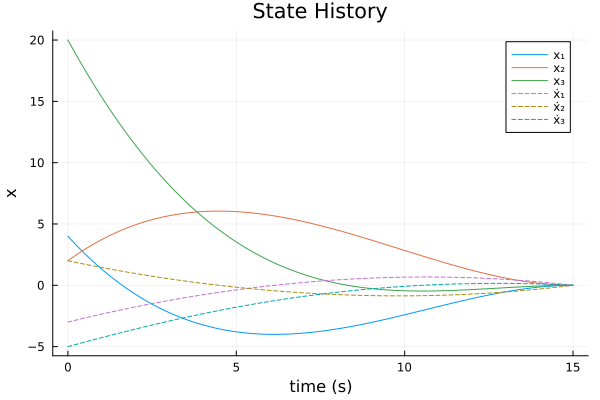

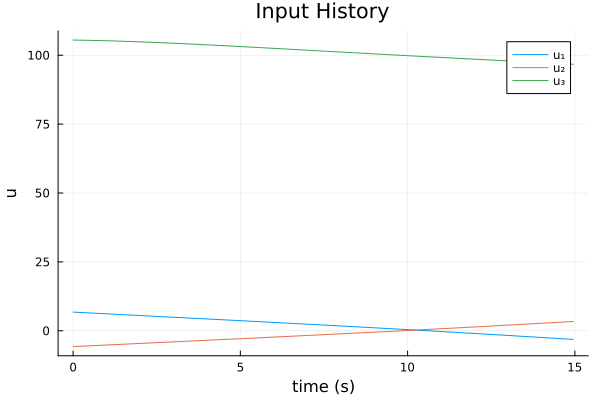

In [11]:
# Let's solve

nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 1e-1*I(nx)
R = 1e-0*I(nu)
Qf = 100*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -170*ones(nu)
u_max =  170*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*1; 
cone_scale = 1  # very fragile for each problem

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# X = Xref*1
# U = Uref*1
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
u_ = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4, max_iters = 20, verbose = true, ρ = 1e0, ϕ = 10.0);
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

For TrajOpt, it needs more tricks to get better results:
- Hessian of the projection => better approximation (done)
- Scaling between conic constraints and other ones (1/rho, Zac did not buy it)
- Solution polishing?

Maybe, we don't care about TrajOpt problem, except from a good initial guess, there is nothing we can tune to get better performance. How about reset mpc?

In [6]:
# Check conic violation
convio = 0.0
for k = 1:N-1
    Uc = cone_u(params, U[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end
Xref .= Xn;
Uref .= Un;

-0.37319739903221105

-0.41448735088956035

-0.4557352119690474

-0.4969415553641987

-0.5381069058355124

-0.5792318034024859

-0.6203168069860681

-0.6613624232513224

-0.7023692052460735

-0.7433376751048755

-0.7842683600173999

-0.8251617882755635

-0.8660184695056596

-0.9068389215527244

-0.9476236816797652

-0.9883732346862129

-1.0290881121566926

-1.0697687653718404

-1.11041586439514

-1.1510296826632302

-1.1916109597033575

-1.2321599600633437

-1.2726773571111973

-1.313163638836313

-1.3536191489325136

-1.3940445797279954

-1.4344402783600625

-1.4748067704378434

-1.5151445429703312

-1.555454100411163

-1.5957359072199697

-1.6359904525882278

-1.6762181606615592

-1.7164196757201644

-1.7565953055248018

-1.7967455994815982

-1.836871013987433

-1.8769720290856018

-1.9170491119459951

-1.9571027503275147

-1.9971333982436077

-2.0371415303870295

-2.077127615642673

-2.1170921192731136

-2.1570355095510694

-2.1969582518579287

-2.2368608094220477

-2.2767436401036285

-2.316607226304919

-2.3564520049083324

-2.396278454851279

-2.4360870387074582

-2.475878197485118

-2.5156524085366243

-2.5554101300752015

-2.59515180534223

-2.6348779066693737

-2.6745888881653883

-2.7142851559531502

-2.7539673130962266

-2.793635676147903

-2.8332907361469246

-2.872932956107322

-2.912562789004957

-2.952180684442421

-2.9917871119789368

-3.031382505032173

-3.070967337678562

-3.1105420423095422

-3.1501070915687412

-3.1896629174355873

-3.2292099922679824

-3.268748748728437

-3.3082796571924424

-3.347803148238972

-3.3873196941047796

-3.426829729375825

-3.4663337046984264

-3.505832083651775

-3.545325295543633

-3.5848138056953776

-3.6242980559280884

-3.663778499525238

-3.7032555741259214

-3.742729730952968

-3.7822013758382473

-3.821671078752269

-3.8611391593032067

-3.90060610368468

-3.940072354868035

-3.9795383523166885

-4.019004545582879

-4.058471370772396

-4.0979392685660985

-4.137408642850818

-4.176880038663568

-4.216353774996106

-4.2558302962553824

-4.29531015103605

-4.334793608642501

-4.374281255895657

-4.413773406407457

-4.4532705213043915

-4.492773035671697

-4.532281360088729

-4.571795916820965

-4.6113171188201525

-4.650845388423882

-4.690381136523797

-4.729924762640788

-4.769476674960981

-4.809037275570384

-4.848606960213902

-4.8881861221961795

-4.927775146059476

-4.967374423604805

-5.006984333604622

-5.046605241746397

-5.086237486013061

-5.1258815258821775

-5.165537626735129

-5.205206159404991

-5.244887468504843

-5.284581888479952

-5.324289743180627

-5.3640113490307435

-5.40374700892042

-5.4434970297688015

-5.483261687222397

-5.523041257739508

-5.562836002804687

-5.602646171650003

-5.642471993758486

-5.682313698682046

-5.7221714784844995

-5.762045521665318

-5.801935994517217

-5.841843042908692

-5.881766792077503

-5.9217073433974985

-5.961664772347336

-6.001639129399317

-6.041630435109273

-6.081638678191189

-6.121663814242663

-6.161705762984457

-6.2017644037994435

-6.241839573642574

-6.28193106313591

-6.322038612873071

-6.362161907925387

-6.402300574401172

-6.442454174314642

-6.482622171789992

-6.522804056312675

-6.562999079449897

-6.603206499686152

-6.643425433136681

-6.683654965698336

-6.723893922855428

-6.764141089225377

-6.804395072826039

-6.844654312897717

-6.88491706350097

-6.925181368770023

-6.9654450423451815

-7.005705636316842

-7.045960411997509

-7.086206280299527

-7.126439870300135

-7.166657260581861

-7.206854142942573

-7.247025625288751

-7.287166284094058

-7.327269862776294

-7.367329377481809

-7.407336886567081

-7.447283364948889

-7.487158527135721

-7.526950617601943

-7.5666461556230304

-7.606229612843151

-7.645683134667442

-7.684985899124723

-7.724113750795805

-7.763038403654251

-7.801726704058381

-7.840139396053964

-7.878229967960899

-7.915942993993166

-7.953211882596905

-7.989956503609587

-8.026079618546525

-8.061462884275773

-8.095961535573688

-8.129397918320977

-8.161553722677127

-8.192160817828707

-8.220891420882909

-8.247348937196

-8.271062077002725

-8.291487170509894

-8.308025442656362

-8.32006244828629

-8.327032900841704

-8.328503429441593

-8.324251364796721

-8.31430987491452

-8.298959410876618

-8.278669568548827

-8.254016453722441

-8.225604218445678

-8.194008153654522

-8.159742785514391

-8.123249903289022

-8.084899177627447

-8.044995198820484

-8.00378687422797

-7.961476934399413

-7.918230502969054

-7.874182374616295

-7.829442992083638

-7.7841032620627795

-7.7382383954040765

-7.691910954276283

-7.645173266884431

-7.598069342774463

-7.5506363960474

-7.502906061019363

-7.454905366579114

-7.406657520780435

-7.358182545723243

-7.309497793863873

-7.26061837001188

-7.211557477963864

-7.162326706632666

-7.112936267368269

-7.063395191717431

-7.013711496965783

-6.963892325320494

-6.913944061428649

-6.863872432011035

-6.813682590610947

-6.763379190339827

-6.712966445448394

-6.662448185377223

-6.611827900657135

-6.561108782908646

-6.510293760000801

-6.459385525630363

-6.408386566594577

-6.357299186152403

-6.306125522189934

-6.25486757042944

-6.20352719381124

-6.152106142040479

-6.100606061310425

-6.049028506007207

-5.997374950286976

-5.945646793387515

-5.89384537218298

-5.84197196516817

-5.790027799442107

-5.738014058032851

-5.685931884096066

-5.633782385779089

-5.581566640444462

-5.529285699212171

-5.476940594408065

-5.424532323415879

-5.372061889448163

-5.319530267358365

-5.266938424312544

-5.214287319164526

-5.161577903793293

-5.108811125712981

-5.05598792974961

-5.003109259520743

-4.950176059900272

-4.897189277926248

-4.8441498642645575

-4.791058775615026

-4.737916974092855

-4.6847254305334545

-4.631485124802467

-4.5781970472873965

-4.52486220020207

-4.47148159892191

-4.418056273371972

-4.364587269492594

-4.311075650810496

-4.2575225001462575

-4.203928921492505

-4.150296042134922

-4.096625014810904

-4.042917020714129

-3.9891732719463935

-3.9353950151649864

-3.8815835352160963

-3.827740541791263

In [7]:
### MPC style with other solver ###
include("mpc_JuMP.jl")

Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
# x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [4.4, 2.2, 20.2, -3.03, 2.02, -5.05]

xg = [0,0,0,0,0,0.0]
Q = 100e-1*I(nx)  # make this higher!
R = 1e-1*I(nu)
Qf = 10*I(nx) # change this!
θ_thrust_max = 5.0  # increase max thrust from plan!

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*1; 
cone_scale = 1e0

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = [-mass * gravity for k = 1:Nsim-1]
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [-mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
    "verbose"=>false,
    "eps_abs"=>1e-8,
    "eps_rel"=>1e-8,
    "rho"=>1e-2,
    "scaling"=>0,
    "alpha"=>1.0)
Random.seed!(1);
for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i], Xref = Xref[i:Nh+i-1])  # update ref
    
    pos_norm = norm(Xhist[i][1:3], Inf) / 100 # 1% noise
    vel_norm = norm(Xhist[4:6], Inf) / 1e6 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    Xhist[i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    
    # Uhist[i] = mpc_JuMP(optimizer, params1, Xhist[i], A, B, f)
    
    # X = [Xhist[i] for i = 1:Nh]  # reset, avoid warm-staring
    # U = [-mass * gravity for k = 1:Nh-1]
    X[1] .= Xhist[i]; Uhist[i] = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-4,max_iters = 10,verbose = false,ρ = 100, ϕ = 10.0) 
    
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

1. COSMO gives better tracking results
2. Ours always need warm-start

In [8]:
# Check conic violation
convio = 0.0
for k = 1:Nsim-1
    Uc = cone_u(params, Uhist[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end

-0.3731973990319428

-2.8023753362914148

-3.2135980381110842

-3.6518598474043182

-2.8843699776063945

-3.6363369321618455

-4.020863168493313

-3.7057046542034824

-2.750107639872998

-2.914425488161031

-2.2624272635130014

-1.247721438391583

-2.3364844591767895

-3.6216486185115135

-4.0064595893748995

-3.864436952747022

-4.139570446215339

-3.5693844408111257

-3.554116685474277

-4.012112415404741

-3.4340545816625294

-2.5593724927356156

-3.091653854140615

-3.5594296408131765

-3.1820692919333027

-2.920934850818915

-2.799038093826332

-2.8251828967368615

-2.601522134613357

-3.0047518276970315

-2.834243782742801

-2.5146120386667237

-2.3508169532908534

-1.95478113193366

-1.5980142134381845

-2.3478565636461894

-2.157936186501839

-2.2422135823893203

-1.8265715484961929

-2.226372024701747

-1.684680456021188

-1.819088928383053

-1.8803854883091455

-0.6751337648302798

-1.5911213935701554

-1.5318464585545062

-1.0608638422527772

-0.27814069475401837

-0.17435626365928414

-0.71336806324077

-0.6194767001744097

-0.19262832841892497

-0.21400456536258616

-0.49691969803616054

-0.5105711810616445

-0.2470257125438149

-0.4894551200465056

-0.449471630224739

-0.44257105182295753

-0.7262144764368994

-1.0312595293122158

-1.1652940513303287

-0.8994409419522338

-1.3151240417477164

-1.7817797293884627

-1.7744103770313142

-1.8239294587878394

-1.7920844326935255

-1.7899346008612333

-2.242357140233902

-2.3411451264266994

-2.6181653212897302

-2.8614181067577142

-2.6362588132507687

-2.4823102359199787

-2.3706477023689096

-2.110243220266484

-2.2096457743915447

-2.9152504662500505

-3.2363344523834376

-3.3597224242462955

-3.4274787116693597

-3.218591124586644

-3.1926329899976

-3.1732752494899197

-3.389916373967684

-3.5350913070824603

-3.8744755331702168

-3.5552065689231735

-3.591849435103729

-3.774064208001054

-3.9099431873039876

-3.9208954236054776

-4.112346979545545

-4.1530855704014975

-4.420274471171709

-4.451166879250282

-4.508034415263974

-4.684817856907756

-4.531786285706244

-4.375836353032975

-4.47653640187175

-4.569819336314999

-4.392248359712924

-3.983950849157962

-3.7297559186055924

-3.624365287911216

-3.8768615542149742

-4.3426428392720196

-4.231758042247888

-4.500077509844942

-4.704401076801656

-4.701025823145811

-4.505146968741314

-4.557472465297704

-4.690111191619309

-4.958628526551161

-5.045582577371907

-5.418279148208821

-5.471943599074091

-5.8624412429496084

-6.0117822755747685

-5.972104616786988

-6.178797606423728

-6.4409696913134

-6.183369156865815

-6.324986759934073

-6.343690670357976

-6.214866020920198

-6.024744662866505

-6.084812944414046

-6.102601041536532

-6.048585238827957

-6.0286570347383

-5.646656001325061

-5.4403336514709615

-5.588953428302074

-5.838339539958895

-5.827529056336333

-5.597378063590127

-5.67908908754071

-5.7557559518491885

-5.423194081272998

-5.662652817606112

-5.658481408345675

-6.05264136146122

-5.9588854730062435

-6.114794472189574

-6.033644445813298

-6.354834272836969

-6.540482589583844

-6.603604396433297

-6.642650514520389

-6.540647455842338

-6.359328536520197

-6.305752227644885

-6.278158435411635

-6.411129219097466

-6.281924183326884

-6.264038345595888

-6.402836950788083

-6.457099133589294

-6.641314872545268

-6.4338553220777115

-6.354570570492228

-6.577066248936576

-6.575896034129368

-6.59601045147112

-6.2461295411166144

-6.2488581720573

-6.276337573386838

-6.42140550085883

-6.658371973185501

-6.8560451244166645

-6.754768457414

-6.822970280161389

-6.741916452704723

-6.646502956747229

-6.512470055608626

-6.4323035535660775

-6.634034850464754

-6.768863969998571

-7.048919568380732

-7.127630360869742

-7.15679165664972

-7.154228719475176

-7.402025807033502

-7.4012733494236915

-7.482202046426583

-7.537206798856126

-7.594321874533388

-7.370612794880129

-7.412266753595728

-7.765707921261134

-7.971565474984546

-8.002782398835263

-7.893870846483013

-7.974798054792155

-8.075559805930375

-8.282655226515256

-8.276858986874734

-8.347418542182321

-8.387023347976273

-8.175757846856355

-8.157013388963959

-8.158415128093747

-8.18964636463188

-8.131502042587783

-8.132740289275237

-7.996385140058655

-7.961876249646529

-8.040465037272964

-8.044442459460905

-8.044242243503007

-8.041602973464107

-8.047574601089902

-8.172637454789525

-8.231437394915748

-7.953840115569836

-7.870736744936207

-7.999668508186847

-8.01315719368053

-8.033196149891046

-8.01090453777513

-8.106110787441809

-8.060786340918693

-7.969164516391606

-7.825100017912403

-7.632718177193014

-7.629443321316924

-7.538209129879323

-7.55597290035609

-7.55896437085789

-7.5250478370566105

-7.5452457939970765

-7.569177910621031

-7.564311994295974

-7.53071771254532

-7.513571026395499

-7.409217606881629

-7.323436294042344

-7.217537963745493

-7.180501141619285

-7.150604403998087

-7.000361932213387

-6.974782700691615

-6.937692934209993

-6.830470669818305

-6.807975066412226

-6.731425447245604

-6.674273650553158

-6.623554503252778

-6.573134629095187

-6.531374807145772

-6.473133307564321

-6.499970847109365

-6.472409686086714

-6.422428313522133

-6.347530440933429

-6.283863611696466

-6.223094677532793

-6.165475124690936

-6.094667150087439

-6.014329892295743

-5.970804262510077

-5.881754774521367

-5.791143675106575

-5.72639390647921

-5.675058445909622

-5.612941313604335

-5.522294100590412

-5.4786541496257675

-5.429492538070958

-5.369512185671926

-5.308592352491441

-5.250866382448358

-5.1903994298691085

-5.135764719802978

-5.081838398252809

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

traj_error = maximum(norm.(e_sim_m, Inf)) = 2.1618429073236296


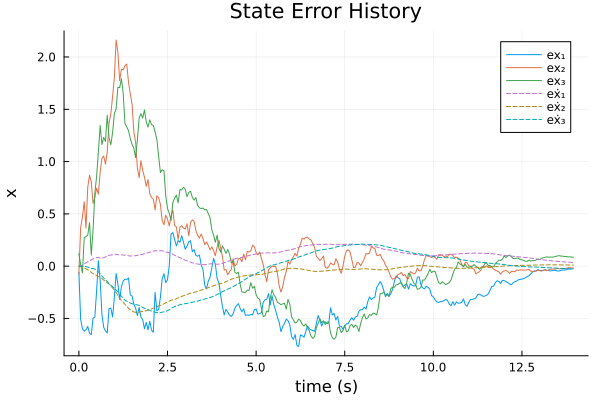

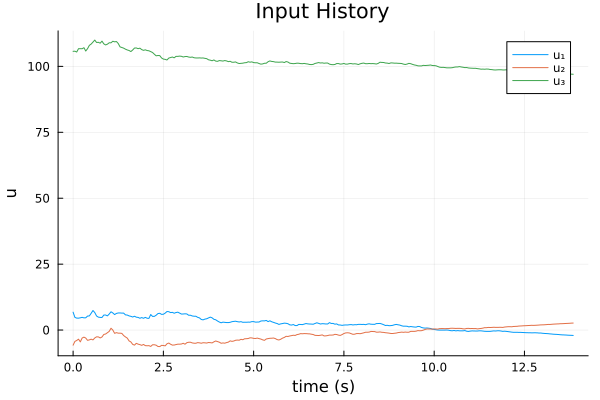

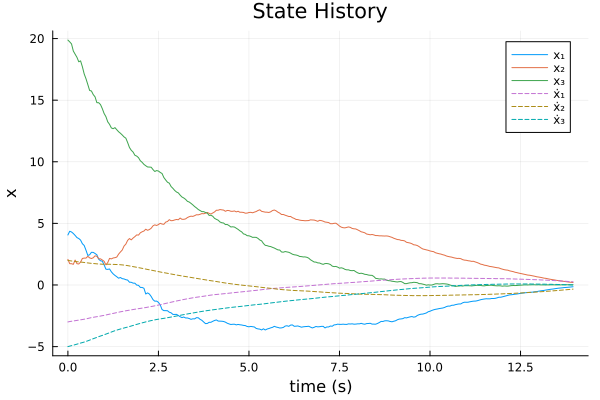

In [9]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
@show traj_error = maximum(norm.(e_sim_m, Inf))
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash], 
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))